In [1]:
import numpy as np

from gym.envs.toy_text.blackjack import BlackjackEnv, sum_hand, is_bust, cmp, score, is_natural
import seaborn as sns
import matplotlib.pyplot as plt
from collections import namedtuple
import itertools

In [70]:
State = namedtuple('State', ['player_sum', 'dealer_card', 'usable_ace', 'memory'])

class RunningStatistic:
    def __init__(self, default_value):
        self.seen = 0
        self._value = None
        self.default_value = default_value

    @property
    def value(self):
        return self._value if self.seen else self.default_value

    def feed(self, value, num_samples):
        if not num_samples:
            return
        if not self.seen:
            self._value = value
        else:
            self._value /= (1.0 + num_samples / self.seen)
            self._value += value / (1.0 + self.seen / num_samples)
        self.seen += num_samples

    def reset(self):
        self.seen = 0
        self._value = None
        
        
def draw_card(np_random, deck):
    return int(np_random.choice([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], p=deck / deck.sum()))        


def step_with_memory(self, action, deck):
    assert self.action_space.contains(action)
    if action:  # hit: add a card to players hand and return
        self.player.append(draw_card(self.np_random, deck))
        if is_bust(self.player):
            done = True
            reward = -1.
        else:
            done = False
            reward = 0.
    else:  # stick: play out the dealers hand, and score
        done = True
        while sum_hand(self.dealer) < 17:
            self.dealer.append(draw_card(self.np_random, deck))
        reward = cmp(score(self.player), score(self.dealer))
        if self.natural and is_natural(self.player) and reward == 1.:
            reward = 1.5
    return self._get_obs(), reward, done, {}
        

class Agent:
    def __init__(self, actions=(-1, 1), allow_split=False):
        if allow_split:
            actions += (-1,)
        self.q = {
            State(player_sum, dealer_card, usable_ace, cards_left): tuple(RunningStatistic(x) for x in actions) 
            for player_sum in range(2, 22)
            for dealer_card in range(1, 11)
            for usable_ace in [True, False]
            for cards_left in range(-50, 51)
        }
        self.train = False
        self.actions_num = len(actions)
        self.episode = []
        self.allow_split = allow_split
        
    def _act_train(self, state):
        raise NotImplementedError()
        
    def _q(self, state):
        return np.array([x.value for x in self.q[state]])
    
    def _greedy(self, state, can_split=False):
        q = self._q(state)
        if self.allow_split and not can_split:
            return np.argmax(q[:-1])
        return np.argmax(q)
    
    def set_train(self, train):
        self.train = train
        
    def _state(self, observation):
        player_sum, dealer_card, usable_ace, cards_left = observation
        return State(player_sum, dealer_card, usable_ace, 0)
    
    def act(self, observation, can_split=False):
        state = self._state(observation)
        if state not in self.q:
            print(state)
            return False
        if self.train:
            action = self._act_train(state, can_split)
            self.episode.append((state, action))
            return action
        else:
            return self._greedy(state)
        
    def propagate_reward(self, reward):
#         print(self.episode, reward)
        for state, action in self.episode:    
            self.q[state][action].feed(reward, 1)
        self.episode = []
        
    def strategy(self):
        with_usable_ace = np.array([self._greedy(State(player_sum, dealer_card, True, 0)) 
                                    for dealer_card in range(1, 11)
                                    for player_sum in range(2, 22)]).reshape(10, -1)
        wo_usable_ace = np.array([self._greedy(State(player_sum, dealer_card, False, 0)) 
                                  for dealer_card in range(1, 11)
                                  for player_sum in range(2, 22)]).reshape(10, -1)
        return with_usable_ace, wo_usable_ace
    
        
class SimpleAgent(Agent):
    def __init__(self):
        super().__init__()
        for state in self.q:
            if state.player_sum >= 19:
                self.q[state] = (RunningStatistic(1.), RunningStatistic(-1.))
    
    
class MCControlAgent(Agent):
    def __init__(self, epsilon, allow_double=False, with_memory=False, allow_split=False):
        actions = (-1, 1)
        if allow_double:
            actions += (-1,)
        super().__init__(actions, allow_split)
        for state in self.q:
            self.q[state] = tuple(RunningStatistic(np.random.rand()) for _ in range(self.actions_num))
        self.epsilon = epsilon
        self.with_memory = with_memory
        self.allow_split = allow_split
        
    def _state(self, observation):
        player_sum, dealer_card, usable_ace, cards_left = observation
        return State(player_sum, dealer_card, usable_ace, 0 if not self.with_memory else cards_left)
    
    def _act_train(self, state, can_split=False):
        actions_num = self.actions_num 
        if self.allow_split and not can_split:
            actions_num -= 1
        if np.random.rand() < self.epsilon or any(not x.seen for x in self.q[state][:actions_num]):
            return np.random.randint(0, actions_num)            
        return self._greedy(state, can_split)
        

class BlackjackSimulator:
    def __init__(self, agent, natural=True, allow_double=False, with_memory=False, allow_split=False):
        self.agent = agent
        self.env = BlackjackEnv(natural)
        self.allow_double = allow_double
        self.with_memory = with_memory
        self.deck = np.ones(10) * 4
        self.deck[-1] = 16
        self.cards_value = np.array([-1, 0.5, 1, 1, 1.5, 1, 0.5, 0, -0.5, -1])
        if self.with_memory:
            self.env.step = step_with_memory
        self.allow_split = allow_split
        
    
    def _reset(self):
        if self.with_memory and self.deck.sum() < 15:
            self.deck = np.ones(10) * 4
            self.deck[-1] = 16      
            
        if self.with_memory:
            deck = np.array([-1])
            while np.any(deck < 0):
                observation = self.env.reset()
                deck = self.deck.copy()
                for i in self.env.dealer + self.env.player:
                    deck[i - 1] -= 1
            for i in self.env.dealer[:1] + self.env.player:
                self.deck[i - 1] -= 1
            return observation
            
        return self.env.reset()
    
    
    def _hit(self):        
        if self.with_memory:
            observation, _, done, _ = step_with_memory(self.env, True, self.deck)
            while self.deck[self.env.player[-1] - 1] <= (0 if self.env.player[-1] != self.env.dealer[1] else 1):
                self.env.player = self.env.player[:-1]
                observation, _, done, _ = step_with_memory(self.env, True, self.deck)
            self.deck[self.env.player[-1] - 1] -= 1            
        else:
            observation, _, done, _ = self.env.step(True)
        return observation, done
        
        
    def _stick(self):
        if self.with_memory:
            deck = np.array([-1])
            while np.any(deck < 0):
                deck = self.deck.copy()
                self.env.dealer = self.env.dealer[:2]
                _, reward, _, _ =  step_with_memory(self.env, False, self.deck)
                for i in self.env.dealer[1:]:
                    deck[i - 1] -= 1
            for i in self.env.dealer[1:]:
                self.deck[i - 1] -= 1
        else:
            _, reward, _, _ = self.env.step(False)
        return reward
    
        
    def _observation(self, observation):
        if self.with_memory:
            return observation + (int(2 * (self.deck @ self.cards_value)),)
        else:
            return observation + (0,)
        
    def run_game(self, train=False):
        self.agent.set_train(train)
        observation = self._reset()
        done = False
        splitted_card = None
        
        i = 1
        action = self.agent.act(self._observation(observation), self.allow_split and (self.env.player[0] == self.env.player[1]))
        if self.allow_split and action == self.agent.actions_num - 1:
            splitted_card = self.env.player[0]
            i = 2
            
        for j in range(i):
            if splitted_card:
                self.env.player = [splitted_card]
                action = 1
            while action == 1 and not done:
                if self.deck.sum() == 1:
                    return []
                observation, done = self._hit()
                if not done:
                    action = self.agent.act(self._observation(observation))                
            if action == 2 and self.allow_double:
                if self.deck.sum() == 1:
                    return []
                self._hit()
                
            if j == 0:
                reward = -1
                if not done:
                    if self.deck.sum() == 1:
                        return []
                    reward = self._stick()
                if action == 2 and self.allow_double:
                    reward *= 2
                if train:
                    self.agent.propagate_reward(reward)
            else:
                reward_ = -1
                if not done:
                    reward_ = cmp(score(self.env.player), score(self.env.dealer))
                    if self.env.natural and is_natural(self.env.player) and reward == 1.:
                        reward_ = 1.5
                if action == 2 and self.allow_double:
                    reward_ *= 2
                if train:
                    self.agent.propagate_reward(reward_)
        return [reward] if j == 0 else [reward, reward_]
    
    def eval_agent(self, iters=500000):
        return np.array(list(itertools.chain.from_iterable([simulator.run_game(train=False) for _ in range(iters)]))).mean()
    
    def train_agent(self, rounds=15, train_iterations=500000, eval_iterations=200000):
        x = [0]
        y = [self.eval_agent(eval_iterations)]
        print(f'Initial agent value: {y[-1]}')  
        for i in range(rounds):
            for _ in range(train_iterations):
                self.run_game(train=True)
            x.append((i + 1) * train_iterations)
            y.append(self.eval_agent(eval_iterations))
            print(f'Agent value after {x[-1]} iterations: {y[-1]}')
        return np.array(x), np.array(y)
    
def plot_agent_strategy(agent):
    data1, data2 = agent.strategy()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))
    ax = sns.heatmap(data1.T, square=True, cbar=False, linewidths=.5, ax=ax1, annot=True, 
                     xticklabels=np.arange(1, 11), yticklabels=np.arange(2, 22))
    ax.invert_yaxis()
    ax.set_xlabel('dealer_card')
    ax.set_ylabel('player_sum')
    ax.set_title('Usable ace')

    ax = sns.heatmap(data2.T, square=True, cbar=False, linewidths=.5, ax=ax2, annot=True,
                     xticklabels=np.arange(1, 11), yticklabels=np.arange(2, 22))
    ax.invert_yaxis()
    ax.set_xlabel('dealer_card')
    ax.set_ylabel('player_sum')
    ax.set_title('No usable ace')    
    

Я реализовал класс BlackjackSimulator, и Agent - которые в совокупности позволяют агенту играть в игру и собирать статистику по этим играм. Я поддержал весь функционал, который нужен для разных пунктов задания, и сделал включение различных "способностей" игрока через параметы: allow_double, with_memory, allow_split

In [4]:
ARGS = {
    'allow_double': False,
    'with_memory': False,
    'allow_split': False
}
simple_agent = SimpleAgent()
simulator = BlackjackSimulator(simple_agent, **ARGS)
simulator.eval_agent()

-0.179019

In [ ]:
SimpleAgent - простой вариант агента, который добирает карты до тех пор, пока у него меньше 19 очков на руках.

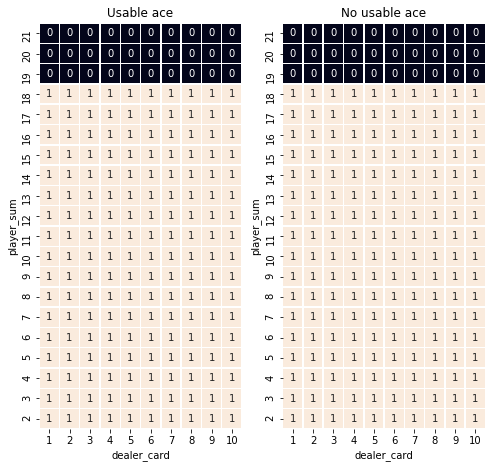

In [75]:
plot_agent_strategy(simple_agent) # 0 - Stick, 1 - Hit

simulator.eval_agent() - вызывает множество симуляций игр и выводит средний выигрыш. Получилось что у SimpleAgent'а средниий выигрыш оказался -0.179019. Интересно, что если всегда говорить Stick, то средний выигрыш будет порядка -0.16, т.е. даже получше, чем у такой наивной стратегии.

Я реализовал обучение по алгоритму Monte Carlo Control с мягкой стратегией. Epsilon передается самому агенту и если он в режие train, то он с вероятностью epsilon будет возвращать случайный action, в остальных случаях будет совершенно самое выгодное действие исходя из текущей накомленной статистики.

In [5]:
ARGS = {
    'allow_double': False,
    'with_memory': False,
    'allow_split': False
}
mc_agent = MCControlAgent(0.01, **ARGS)
simulator = BlackjackSimulator(mc_agent, **ARGS)
simulator.train_agent()

Initial agent value: -0.1685975
Agent value after 500000 iterations: -0.051485
Agent value after 1000000 iterations: -0.040395
Agent value after 1500000 iterations: -0.03356
Agent value after 2000000 iterations: -0.0347
Agent value after 2500000 iterations: -0.030015
Agent value after 3000000 iterations: -0.0316475
Agent value after 3500000 iterations: -0.0324175
Agent value after 4000000 iterations: -0.032395
Agent value after 4500000 iterations: -0.025745
Agent value after 5000000 iterations: -0.0303475
Agent value after 5500000 iterations: -0.0258175
Agent value after 6000000 iterations: -0.02812
Agent value after 6500000 iterations: -0.028615
Agent value after 7000000 iterations: -0.0282375
Agent value after 7500000 iterations: -0.0247425


Я не стал делать тут график, просто периодически вывожу оценку выигрыша агента по ходу обучения, я запускаю отдельно eval стадию, чтобы перевести агента в режим train=False, и он всегда делал жадный выбор action. 

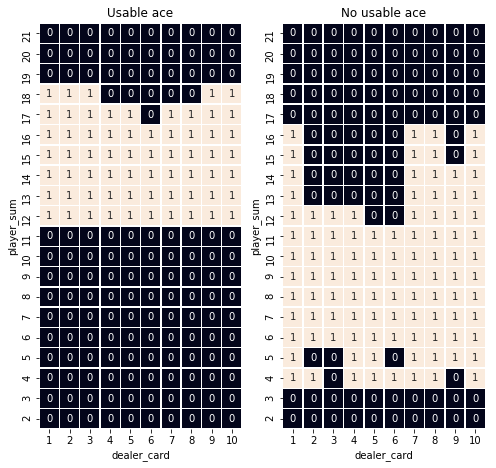

In [76]:
plot_agent_strategy(mc_agent) # 0 - Stick, 1 - Hit

После обучения получилась гораздо более разнообразная картина у поведения агента, оказывается наличие туза очень сильно влияет на оптимальное решение, да и на карту дилера также смотреть небесполезно. Средний выигрыш у такой стратегии -0.0247425, что сильно лучше наивного агентаа, но мы все равно будем проигрывать у казино.

In [6]:
ARGS = {
    'allow_double': True,
    'with_memory': False,
    'allow_split': False
}
mc_double_agent = MCControlAgent(0.01, **ARGS)
simulator = BlackjackSimulator(mc_double_agent, **ARGS)
simulator.train_agent()

Initial agent value: -0.1676775
Agent value after 500000 iterations: -0.049175
Agent value after 1000000 iterations: -0.0396675
Agent value after 1500000 iterations: -0.02887
Agent value after 2000000 iterations: -0.02889
Agent value after 2500000 iterations: -0.0272825
Agent value after 3000000 iterations: -0.0225825
Agent value after 3500000 iterations: -0.0240975
Agent value after 4000000 iterations: -0.02203
Agent value after 4500000 iterations: -0.01597
Agent value after 5000000 iterations: -0.0150325
Agent value after 5500000 iterations: -0.02107
Agent value after 6000000 iterations: -0.0148725
Agent value after 6500000 iterations: -0.0179525
Agent value after 7000000 iterations: -0.015435
Agent value after 7500000 iterations: -0.0170325


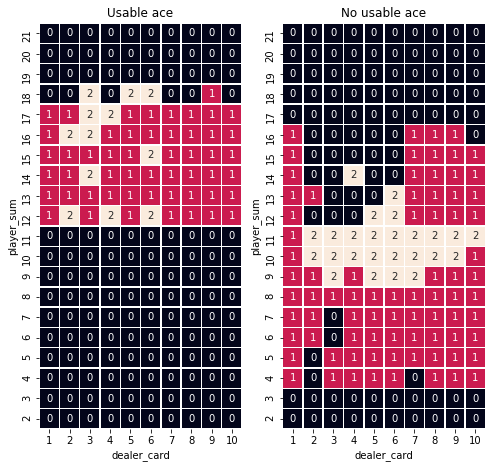

In [77]:
plot_agent_strategy(mc_double_agent) # 0 - Stick, 1 - Hit, 2 - Double

С разрешенным удваиванием ставки можно еще немного улучшить ожидаемый выигрыш до -0.0170325. Ясно что все оценки приведены с долей погрешности, так как они на основе случайных симуляций. Но в целом тренд на улучшение стратегии относительно предыдущей прослеживается. Интересно посмотреть, когда можно быть уверенным в выигрыше и удваивать ставку.

Теперь самое сложное - позволить агенту запоминать карты. Для этого я воспользовался методикой из википедии, где присвоил разным картам вес, можно посчитать сколько карт осталось в колоде, и просуммировать их вес, удвоить, чтобы получить целое число и передать в таком виде агенту. Эта цифра остаточного суммарного веса в колоде будет новой размерностью в пространстве состояний среды. И теперь агент будет запоминать все свои статистики с учетом этого нового состояния.

In [62]:
ARGS = {
    'allow_double': True,
    'with_memory': True,
    'allow_split': False
}
mc_agent_with_memory = MCControlAgent(0.05, **ARGS)
simulator = BlackjackSimulator(mc_agent_with_memory, **ARGS)
simulator.train_agent(rounds=25, train_iterations=2000000, eval_iterations=500000)

Initial agent value: -0.480547
Agent value after 2000000 iterations: -0.045731
Agent value after 4000000 iterations: -0.03284
Agent value after 6000000 iterations: -0.024938
Agent value after 8000000 iterations: -0.019415
Agent value after 10000000 iterations: -0.01581
Agent value after 12000000 iterations: -0.012739
Agent value after 14000000 iterations: -0.012582
Agent value after 16000000 iterations: -0.010261
Agent value after 18000000 iterations: -0.008469
Agent value after 20000000 iterations: -0.006215
Agent value after 22000000 iterations: -0.007922
Agent value after 24000000 iterations: -0.007209
Agent value after 26000000 iterations: -0.004032
Agent value after 28000000 iterations: -0.003028
Agent value after 30000000 iterations: -0.005502
Agent value after 32000000 iterations: -0.004368
Agent value after 34000000 iterations: -0.002281
Agent value after 36000000 iterations: -0.004128
Agent value after 38000000 iterations: -0.002245
Agent value after 40000000 iterations: -0.00

Видно, что в какой то момент даже получили положительную оценку выигрыша, но все таки тут велика доля погрешности, так что в целом выглядит как то что средний выигрыш теперь будет на уровне -0.002303, но если сравнить с предыдущим, можно сказать что за счет добавления памяти агента мы увеличили его эффективность в 8 раз.

Чтобы убедиться в том, что агент научился запоминать, возьмем крайний случай

К примеру, тут видно что если у нас на руке 10 очков, а в колоде остались в основном одни 10ки, вальты, дамы, короли и тузы, то нужно удваивать ставку:

In [152]:
mc_agent_with_memory._q(State(player_sum=10, dealer_card=4, usable_ace=False, memory=-30))

array([0.        , 0.80238215, 2.        ])

Теперь разрешим делать split. Отмечу что я сильно увеличиваю количество итераций, так как число состояний сильно растет, и вероятность попасть в различные редкие состояния которые при этом могут гарантировать выигрыш или проигрыш - очень мала, поэтому тут по максимуму делаем много итераций и также играемся с epsilon.

In [71]:
ARGS = {
    'allow_double': True,
    'with_memory': True,
    'allow_split': True
}
mc_agent_with_split = MCControlAgent(0.05, **ARGS)
simulator = BlackjackSimulator(mc_agent_with_split, **ARGS)
simulator.train_agent(rounds=15, train_iterations=4000000, eval_iterations=500000)

Initial agent value: -0.488906
Agent value after 4000000 iterations: -0.030374
Agent value after 8000000 iterations: -0.021929
Agent value after 12000000 iterations: -0.012262
Agent value after 16000000 iterations: -0.009175
Agent value after 20000000 iterations: -0.009797
Agent value after 24000000 iterations: -0.001988
Agent value after 28000000 iterations: -0.003712
Agent value after 32000000 iterations: -0.003958
Agent value after 36000000 iterations: -0.004729
Agent value after 40000000 iterations: -0.003326
Agent value after 44000000 iterations: -0.004755
Agent value after 48000000 iterations: -0.002995
Agent value after 52000000 iterations: 0.000567
Agent value after 56000000 iterations: -0.000727
Agent value after 60000000 iterations: -0.002473


In [72]:
mc_agent_with_split.epsilon = 0.01
simulator.train_agent(rounds=5, train_iterations=4000000, eval_iterations=500000)

Initial agent value: 0.00028
Agent value after 4000000 iterations: 0.000104
Agent value after 8000000 iterations: -0.001042
Agent value after 12000000 iterations: -0.002147
Agent value after 16000000 iterations: 0.002079
Agent value after 20000000 iterations: -0.001165


In [73]:
simulator.train_agent(rounds=5, train_iterations=4000000, eval_iterations=500000)

Initial agent value: 0.000214
Agent value after 4000000 iterations: -0.002508
Agent value after 8000000 iterations: 0.001158
Agent value after 12000000 iterations: 0.00026
Agent value after 16000000 iterations: -0.0004
Agent value after 20000000 iterations: -0.000651


In [74]:
simulator.train_agent(rounds=5, train_iterations=4000000, eval_iterations=500000)

Initial agent value: -0.002758
Agent value after 4000000 iterations: 0.001518
Agent value after 8000000 iterations: 0.001532
Agent value after 12000000 iterations: -0.000109
Agent value after 16000000 iterations: 0.000743
Agent value after 20000000 iterations: -0.001373


Я несколько раз дообучал агента и в целом видно, что мы не стабильно, но все таки уже явно имеем шансы обыграть казино или по крайней мере не проиграть.

Интересно посмотреть, когда имеет смысл делать сплит.

In [146]:
split_stat = {i: 0 for i in range(1, 11)}
for card in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    for state in mc_agent_with_split.q:
        if state.player_sum == 2 * card and mc_agent_with_split._greedy(state, can_split=True) == 3:
            split_stat[card] += 1

In [147]:
split_stat

{1: 490,
 2: 587,
 3: 557,
 4: 424,
 5: 402,
 6: 831,
 7: 918,
 8: 1044,
 9: 815,
 10: 419}

Это статистика, что если пришла на руку пара определенных карт, сколько всего состояний есть, в которых стоит делать сплит. Цифры примерны так как есть недоступные состояния, проинициализированные случайными весами. Но в целом видно, что на пару восьмерок стоит делать сплит, а пару 10к (вальтов и тп) чаще стоит оставлять. Звучит вполне логично.

Уравнения Беллмана не сделал